In [1]:
###########################################################
###########################################################
###########################################################

## 自变量 挖矿节点 难度目标
## 因变量 出块时间

## 目标：找到一组合适的 PID 参数，使得每挖一个块，做一次难度调节
##      使得连续生成 1000 个块的方差较小
##      多组PID参数做比较 原始难度调整策略做比较

## 使用hash算法 sha1, 一共 160位，难度前导0最多159位

## 目标挖矿平均时间 60s， 记录每个新块的产生时间

## CPU: 2.3 GHz Intel Core i9, 8 - core, use muti-process to simulate the mining nodes

## the root hash of merkle tree is selected by random.

###########################################################
###########################################################
###########################################################

In [2]:
## Support Functions
import hashlib
def sha1(obj: str):
    return hashlib.sha1(str(obj).encode('utf-8')).hexdigest()

In [3]:
## Block
class Block:
    duration = 0
    
    def __init__(self, height, pre_hash, merkle, nouce, transactions):
        self.height = height
        self.pre_hash = pre_hash
        self.merkle = merkle
        self.nouce = nouce
        self.transactions = transactions

    def getHash(self):
        return sha1(self)
    
    def __repr__(self):
        return str(self.pre_hash) + str(self.height) + str(self.merkle) + str(self.nouce)
    
    def printJSON(self):
        # DFS or BFS
        print("Hash:", self.getHash(), "Height:", self.height, "Pre_Hash:", self.pre_hash, "Merkle Hash:", self.merkle, "nouce:", self.nouce)
        pass

In [4]:
## mine difficaulty
## 40 - 4 = 36
## hash value should smaller than DIFFICULTY
import math
DIFFICULTY = 0x0000FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
# DIFFICULTY = 0x0000600000000000000000000000000000000000

print('Mine DIFFICULTY:', math.log2(DIFFICULTY))
# len("00000FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF")
# 5000000000000000000000000000000000000000000
# 22300745198530623141535718272648361505980415

Mine DIFFICULTY: 144.0


In [5]:
import matplotlib.pyplot as plt
def visualization(blocks):
    x = range(len(blocks))
    y = [block.duration if block.duration < 400 else 400 for block in blocks]
    x_standard = range(len(blocks))
    y_standard = [1 for i in x_standard]
    plt.figure(figsize=(20,4)) 
    l1=plt.plot(x,y,'r--',label='Mining')
    l2=plt.plot(x_standard,y_standard,'g--',label='Standard')
    plt.plot(x,y,'ro-',x_standard,y_standard,'g+-')
    plt.xlabel("Height")
    plt.ylabel("Time(s)")
    plt.legend()
    plt.title("Time Analysis")

# visualization([{"duration": 12},{"duration": 40}])

In [6]:
## PID ajustment
## U(t) = Kp*error(t) + Ki*integration(error(t)) + Kd*(error(t) - error(t-1))
## Initialize kp = 1.5  Ki = 1 Kd = 1, more epochs to find the best coefficient
## target = 60s
## error(t) = 60s - real_time
## new_Diffculty = old_Diffculty + U(t)
## old_Difficulty = 5 means 00000 + FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

# kp = 1
# ki = 0.5
# kd = 0.1
# portion = 10000000000000000000000000000000000000000
kp = 0.001
ki = 0.0005
kd = 0.0003
# kd = 0.0005
difficulties = []
# kp = 0.5, ki = 0.2, kd = 0.1
# kp = 0.5, ki = 0.3, kd = 0.1
# kp = 0.5, ki = 0.4, kd = 0.1

# durations = [1,2,3,4,5,6,7,8,9,10]

def adjustmentDifficulty(old_Difficulty,height):
    old_Difficulty = math.log2(old_Difficulty)
    previous_ten_durations = durations[len(durations)-10:len(durations)]
    sum = 0
    for duration in previous_ten_durations:
        sum += duration
        
    new_Difficulty = old_Difficulty * sum / 20 # change difficulty every 10 blocks 
#     print('### change difficulty to: ', new_Difficulty,  ' height is ', height)
    difficulties.append(new_Difficulty)
    print("difficulties: ", difficulties)
    print('********************************************************')
    return math.pow(2,  new_Difficulty)

# adjustmentDifficulty(DIFFICULTY, 10)

In [6]:
## Start mining
import random
import sys
import math
import os
from datetime import datetime
from multiprocessing import Process, Pool, Queue, Manager

epochs = 100
blocks = []
errors = [0]
durations = []
errors_sum = 0
pre_hash = '0'
height = 1
max_nounce = math.pow(2,32)

def long_time_task(i, queue, start, stop, height, pre_hash, merkle, diff):
    start_time = datetime.now()
    print('start: ', start, 'stop: ', stop)
    for z in range(start, stop):
        block = Block(height, pre_hash, merkle, z, [])
        temp = block.getHash()
#         print(temp)
        if int(temp, 16) < diff:
            queue.put(z)
#             print('size: ', queue.qsize(), 'nounce: ', z)
    print('complete process: ', i)
    
merkle = 'fc8a1f655608fd9506559af832554f111e13821c'
nodes_number = 16
unit_nounce = max_nounce // nodes_number
p = Pool()
queue = Manager().Queue()
start_time = datetime.now()

for i in range(nodes_number):
    start = int(i * unit_nounce) # nounce
    stop = int((i + 1) * unit_nounce)
    p.apply_async(long_time_task, args = (i, queue, start, stop, height, pre_hash, merkle, DIFFICULTY))  
p.close()
p.join()

end_time = datetime.now()
duration = end_time - start_time
duration = duration.total_seconds()
print('duration time: %s' % duration)

print(queue.qsize())

start:  1073741824 stop:  1342177280
start:  536870912 stop:  805306368
start:  805306368 stop:  1073741824
start:  0 stop:  268435456
start:  1342177280 stop:  1610612736
start:  268435456 stop:  536870912
start:  1610612736 stop:  1879048192
start:  2147483648 stop:  2415919104
start:  1879048192 stop:  2147483648
start:  2684354560 stop:  2952790016
start:  2415919104 stop:  2684354560
start:  2952790016 stop:  3221225472
start:  3221225472 stop:  3489660928
start:  3489660928 stop:  3758096384
start:  4026531840 stop:  4294967296
start:  3758096384 stop:  4026531840
complete process:  2
complete process:  15
complete process:  13
complete process:  14
complete process:  6
complete process:  9
complete process:  3
complete process:  10
complete process:  11
complete process:  12
complete process:  7
complete process:  8
complete process:  4
complete process:  1
complete process:  5
complete process:  0
duration time: 2206.812459
65402


In [2]:
# print(math.pow(2,15))
# 30720.0/16
print(queue.qsize())

NameError: name 'queue' is not defined

In [11]:
# import math
# logs = []
# for diff in difficulties:
#     logs.append(diff)
#     print(math.log2(diff))
import matplotlib.pyplot as plt
def visualization2(logs):
    x = range(len(logs)-1)
    y = logs[1:]
    plt.figure(figsize=(20,4)) 
    plt.plot(x,y)
    plt.xlabel("Diff")
    plt.ylabel("Time(s)")

visualization2(difficulties)

NameError: name 'difficulties' is not defined

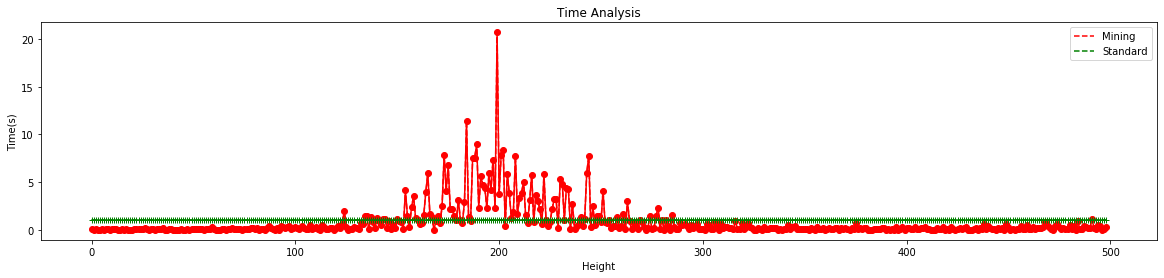

In [28]:
visualization(blocks)

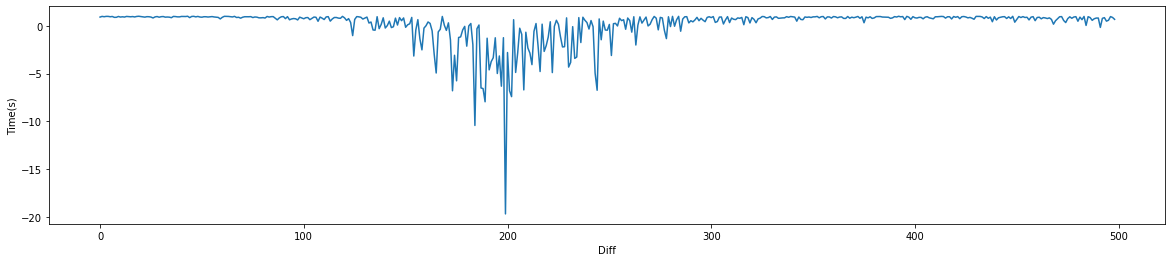

In [26]:
visualization2(errors)

In [149]:
from datetime import datetime
import time
start_time = datetime.now()
time.sleep(2)
end_time = datetime.now()
a = end_time - start_time
a.total_seconds()

2.005374

In [150]:
from multiprocessing import Process, Pool
import os

def run_proc(name):
    print('Run child process %s (%s)...' % (name, os.getpid()))
    
print('Parent process %s.' % os.getpid())
p = Process(target=run_proc, args=('test',))
print('Child process will start.')
p.start()
p.join()
print('Child process end.')

Parent process 6145.
Child process will start.
Child process end.


In [67]:
from multiprocessing import Pool
import os, time, random

def long_time_task(name):
    print('Run task %s (%s)...' % (name, os.getpid()))
    start = time.time()
    time.sleep(random.random() * 3)
    end = time.time()
    print('Task %s runs %0.2f seconds.' % (name, (end - start)))

print('Parent process %s.' % os.getpid())
p = Pool(8)
for i in range(8):
    p.apply_async(long_time_task, args=(i,))
print('Waiting for all subprocesses done...')
p.close()
p.join()

print('All subprocesses done.')

Parent process 6145.
Run task 2 (11449)...
Run task 0 (11447)...
Run task 3 (11450)...
Run task 1 (11448)...
Run task 4 (11451)...
Run task 6 (11453)...
Run task 5 (11452)...
Run task 7 (11454)...
Task 6 runs 0.07 seconds.
Waiting for all subprocesses done...
Task 2 runs 0.50 seconds.
Task 5 runs 0.57 seconds.
Task 3 runs 0.62 seconds.
Task 0 runs 0.87 seconds.
Task 1 runs 1.03 seconds.
Task 7 runs 2.76 seconds.
Task 4 runs 3.00 seconds.
All subprocesses done.


In [11]:
from multiprocessing import Process, Queue
import os, time, random

# 写数据进程执行的代码:
def write(q):
    print('Process to write: %s' % os.getpid())
    for value in ['A', 'B', 'C']:
        print('Put %s to queue...' % value)
        q.put(value)
        time.sleep(random.random())

# 读数据进程执行的代码:
def read(q):
    print('Process to read: %s' % os.getpid())
    while True:
        value = q.get(True)
        print('Get %s from queue.' % value)

# 父进程创建Queue，并传给各个子进程：
q = Queue()
pw = Process(target=write, args=(q,))
pr = Process(target=read, args=(q,))
# 启动子进程pw，写入:
pw.start()
# 启动子进程pr，读取:
pr.start()
# 等待pw结束:
pw.join()
# pr进程里是死循环，无法等待其结束，只能强行终止:
pr.terminate()

Process to write: 12493
Put A to queue...
Process to read: 12494
Get A from queue.
Put B to queue...
Get B from queue.
Put C to queue...
Get C from queue.


In [42]:
from multiprocessing import Pipe, Process

def worker(conn):
    print(conn.recv())
    conn.send("sent from child process")

conn1, conn2 = Pipe()
process = Process(target=worker, args=[conn2])
process.start()

conn1.send("sent from main process")
print(conn1.recv())


sent from main process
sent from child process


In [47]:
import sys
print(sys.maxsize)

9223372036854775807


In [10]:
import math
math.log2(8)

3.0

In [42]:
print(os.cpu_count())

16


In [110]:
from datetime import datetime
t_merkle = 'fc8a1f655608fd9506559af832554f111e13821c'
t_height = 0
t_pre_hash = ""
t_nounce = 0
t_pre = '0'
t_start_time = datetime.now()

for x in range(0,1000000):
    block = Block(t_height, t_pre, t_merkle, x, [])
    t_height += 1
    t_pre = block.getHash()

t_end_time = datetime.now()
t_duration = t_end_time - t_start_time
t_duration = t_duration.total_seconds()
print('duration time: %s' % t_duration)


duration time: 2.751718


In [126]:
3458764513820541015 % 461168601842738 * 2.7/1000000

0.0162405

In [8]:
# change difficulty every 10 blocks 
# def adjustmentDifficulty(old_Difficulty,height):
#     old_Difficulty = math.log2(old_Difficulty)
#     previous_ten_durations = durations[len(durations)-10:len(durations)]
#     sum = 0
#     for duration in previous_ten_durations:
#         sum += duration     
#     new_Difficulty = old_Difficulty * sum / 20 
#     return math.pow(2,  new_Difficulty)

In [ ]:
## Start mining
# import random
# import sys
# import os
# from datetime import datetime
# from multiprocessing import Process, Pool, Queue, Manager

# epochs = 100
# blocks = []
# errors = [0]
# durations = []
# errors_sum = 0
# pre_hash = '0'
# height = 1
# max_nounce = sys.maxsize
# one_hash_time = 2.7/1000000
# actual_numbers = 2000000
# actual_unit_nounce = max_nounce // actual_numbers


# def long_time_task(i, queue, start, height, pre_hash, merkle, DIFFICULTY):
#     print('Run task %s (%s)...' % (i, os.getpid()))
#     start_time = datetime.now()
#     while queue.empty():
#         print("process: %s nounce: %s" % (i, start))
#         block = Block(height, pre_hash, merkle, start, [])
#         if int(block.getHash(),16) < DIFFICULTY:
#             block.printJSON()
#             queue.put(start)
#             break
#         else:
#             start += 1
    
# while height < 1000:
#     print('Epoch %s, Parent process %s, mining...' % (height, os.getpid()))
#     merkle = sha1(random.random())
#     nodes_number = 16
#     unit_nounce = max_nounce // nodes_number
#     p = Pool()
#     queue = Manager().Queue()

#     for i in range(nodes_number):
#         start = i * unit_nounce # nounce
#         p.apply_async(long_time_task, args = (i, queue, start, height, pre_hash, merkle, DIFFICULTY))  
#     p.close()
#     p.join()
    
#     result_nounce = queue.get(True)
#     duration = (result_nounce % actual_unit_nounce) * one_hash_time
    
#     block = Block(height, pre_hash, merkle, result_nounce, [])
#     block.duration = duration
#     durations.append(duration)
#     blocks.append(block)
    
#     error = (1 - duration)/1
#     errors.append(error)
#     errors_sum += error
    
#     DIFFICULTY = adjustmentDifficulty(DIFFICULTY,height)

#     height += 1
#     pre_hash = block.getHash()

In [2]:
import math
abs(-1)

1